In [28]:
!pip install plotly
!pip install little_mallet_wrapper
!pip install wordcloud
!pip install gensim

# 1. Setting up

In [29]:
import pandas as pd
import numpy as np
import plotly.express as px
from os import listdir
from os.path import isfile, join
import glob 
import os
import re
import matplotlib.pyplot as plt
import little_mallet_wrapper as lmw
from pathlib import Path
from collections import Counter 
from wordcloud import WordCloud
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
import gensim
from gensim.utils import simple_preprocess
from gensim.corpora import Dictionary
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/juliettezaccour/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/juliettezaccour/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/juliettezaccour/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/juliettezaccour/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [30]:
os.getcwd()

'/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project'

In [31]:
# setting the path
path = '/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/'

# getting a list of all files
AllFiles = glob.glob(path + "*.txt")

In [32]:
# list of all txt files in the path folder

# list to store files
list_of_txtfiles = []

# iterate through directory
for paths in os.listdir(path):
    # check if current path is a file
    if os.path.isfile(os.path.join(path, paths)):
        list_of_txtfiles.append(paths)

In [33]:
# Creating a df with all files, company and report year

filenames = [Path(file).stem for file in AllFiles]

companies = []
for file in filenames:
    companies.append(file[:-5])
    
years = []
for file in filenames:
    years.append(file[-4:])
    
df = pd.DataFrame(list(zip(filenames, years, companies)), columns=['Filename','Year','Company'])
df = df.reset_index().rename(columns={'index':'id'}).set_index('id')
df

Filename  Year       Company
id                                         
0          NYSE_IT_2019  2019       NYSE_IT
1     NASDAQ_CMCSA_2021  2021  NASDAQ_CMCSA
2        NYSE_LDOS_2018  2018     NYSE_LDOS
3          LSE_VOD_2009  2009       LSE_VOD
4          OTC_TCS_2016  2016       OTC_TCS
...                 ...   ...           ...
1092       LSE_VOD_2004  2004       LSE_VOD
1093       LSE_VOD_2010  2010       LSE_VOD
1094   NASDAQ_CDNS_2020  2020   NASDAQ_CDNS
1095   NASDAQ_NXPI_2020  2020   NASDAQ_NXPI
1096     NYSE_LDOS_2015  2015     NYSE_LDOS

[1097 rows x 3 columns]

In [34]:
companies = df['Company'].value_counts().to_frame().rename(columns={'Company':'nb_of_reports_in_dataset'})
companies.to_csv('companieslist.csv')
companies
# 208 unique companies

nb_of_reports_in_dataset
NYSE_STM                           24
NYSE_SNE                           22
NYSE_DELL                          22
NYSE_CAJ                           22
OTC_FJTSF                          21
...                               ...
NASDAQ_DIOD                         1
LSE_AVV                             1
NASDAQ_SSYS                         1
NASDAQ_AVID                         1
NASDAQ_GFS                          1

[210 rows x 1 columns]

In [35]:
# manually sorted each company depending on whether they are Fortune 100 / FAANG or not
# re-importing that labeled list and joining it back to the main df:
dfdf = pd.read_csv('companieslist_labeled.csv').rename(columns={'Unnamed: 0':'Company'})

In [36]:
#companies_list = df.Company.values.tolist()
companynames_list = dfdf.company_name.unique().tolist()
companynames_list2 = [x.lower() for x in companynames_list]
companynames_list.append(companynames_list2)

In [37]:
# Custom list of stopwords: add to it if I notice anything I want to remove
stopwords_custom_list = ['introduction', 'conclusion', 'contents', 'content', 'table', 'figure', 'figures', 'tables',
                        'per','malpensa','cisco','qualcomm','page','pages','also','www','com']

# adding company names to the stopwords list
companynames_list = [str(x).lower() for x in companynames_list]

for x in companynames_list:
    #x.lower()
    stopwords_custom_list.append(x)

# adding countries to the stopwords list
countries = ['Afghanistan', 'Aland Islands', 'Albania', 'Algeria', 'American Samoa', 'Andorra', 'Angola', 'Anguilla', 'Antarctica', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bermuda', 'Bhutan', 'Bolivia, Plurinational State of', 'Bonaire, Sint Eustatius and Saba', 'Bosnia and Herzegovina', 'Botswana', 'Bouvet Island', 'Brazil', 'British Indian Ocean Territory', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde', 'Cayman Islands', 'Central African Republic', 'Chad', 'Chile', 'China', 'Christmas Island', 'Cocos (Keeling) Islands', 'Colombia', 'Comoros', 'Congo', 'Congo, The Democratic Republic of the', 'Cook Islands', 'Costa Rica', "Côte d'Ivoire", 'Croatia', 'Cuba', 'Curaçao', 'Cyprus', 'Czech Republic', 'Denmark', 'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia', 'Ethiopia', 'Falkland Islands (Malvinas)', 'Faroe Islands', 'Fiji', 'Finland', 'France', 'French Guiana', 'French Polynesia', 'French Southern Territories', 'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Gibraltar', 'Greece', 'Greenland', 'Grenada', 'Guadeloupe', 'Guam', 'Guatemala', 'Guernsey', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Heard Island and McDonald Islands', 'Holy See (Vatican City State)', 'Honduras', 'Hong Kong', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Iran, Islamic Republic of', 'Iraq', 'Ireland', 'Isle of Man', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jersey', 'Jordan', 'Kazakhstan', 'Kenya', 'Kiribati', "Korea, Democratic People's Republic of", 'Korea, Republic of', 'Kuwait', 'Kyrgyzstan', "Lao People's Democratic Republic", 'Latvia', 'Lebanon', 'Lesotho', 'Liberia', 'Libya', 'Liechtenstein', 'Lithuania', 'Luxembourg', 'Macao', 'Macedonia, Republic of', 'Madagascar', 'Malawi', 'Malaysia', 'Maldives', 'Mali', 'Malta', 'Marshall Islands', 'Martinique', 'Mauritania', 'Mauritius', 'Mayotte', 'Mexico', 'Micronesia, Federated States of', 'Moldova, Republic of', 'Monaco', 'Mongolia', 'Montenegro', 'Montserrat', 'Morocco', 'Mozambique', 'Myanmar', 'Namibia', 'Nauru', 'Nepal', 'Netherlands', 'New Caledonia', 'New Zealand', 'Nicaragua', 'Niger', 'Nigeria', 'Niue', 'Norfolk Island', 'Northern Mariana Islands', 'Norway', 'Oman', 'Pakistan', 'Palau', 'Palestinian Territory, Occupied', 'Panama', 'Papua New Guinea', 'Paraguay', 'Peru', 'Philippines', 'Pitcairn', 'Poland', 'Portugal', 'Puerto Rico', 'Qatar', 'Réunion', 'Romania', 'Russian Federation', 'Rwanda', 'Saint Barthélemy', 'Saint Helena, Ascension and Tristan da Cunha', 'Saint Kitts and Nevis', 'Saint Lucia', 'Saint Martin (French part)', 'Saint Pierre and Miquelon', 'Saint Vincent and the Grenadines', 'Samoa', 'San Marino', 'Sao Tome and Principe', 'Saudi Arabia', 'Senegal', 'Serbia', 'Seychelles', 'Sierra Leone', 'Singapore', 'Sint Maarten (Dutch part)', 'Slovakia', 'Slovenia', 'Solomon Islands', 'Somalia', 'South Africa', 'South Georgia and the South Sandwich Islands', 'Spain', 'Sri Lanka', 'Sudan', 'Suriname', 'South Sudan', 'Svalbard and Jan Mayen', 'Swaziland', 'Sweden', 'Switzerland', 'Syrian Arab Republic', 'Taiwan, Province of China', 'Tajikistan', 'Tanzania, United Republic of', 'Thailand', 'Timor-Leste', 'Togo', 'Tokelau', 'Tonga', 'Trinidad and Tobago', 'Tunisia', 'Turkey', 'Turkmenistan', 'Turks and Caicos Islands', 'Tuvalu', 'Uganda', 'Ukraine', 'United Arab Emirates', 'United Kingdom', 'United States', 'United States Minor Outlying Islands', 'Uruguay', 'Uzbekistan', 'Vanuatu', 'Venezuela, Bolivarian Republic of', 'Viet Nam', 'Virgin Islands, British', 'Virgin Islands, U.S.', 'Wallis and Futuna', 'Yemen', 'Zambia', 'Zimbabwe']
countries2 = [x.lower() for x in countries]

for x in countries:
    stopwords_custom_list.append(x)
    
for x in countries2:
    stopwords_custom_list.append(x)

stopwords_custom_list[5:]

# if companies are still apearing in topic models, then do companynames_list.to_lower() so they're all lowercase

['figure',
 'figures',
 'tables',
 'per',
 'malpensa',
 'cisco',
 'qualcomm',
 'page',
 'pages',
 'also',
 'www',
 'com',
 'stmicroelectronics',
 'sony corporation',
 'canon inc.',
 'dell',
 'fujitsu',
 'telus',
 'samsung sdi co.',
 'microsoft',
 'vodafone',
 'ibm',
 'verizon',
 'seagate',
 'cisco',
 'acer',
 'chl',
 'qualcomm',
 'logitech',
 'infosys',
 'huawei',
 'tata consultancy services',
 'bosch',
 'seiko epson corporation',
 'rexel',
 'nortonlifelock',
 'bell canada',
 'intel',
 'seagen',
 'texas instruments',
 'celestica',
 'hp',
 'at&t inc.',
 'flex',
 'lg',
 'bang & olufsen',
 'comcast',
 'teradata',
 'simcorp',
 'applied materials, inc.',
 'apple',
 'america movil',
 'accenture',
 'sunpower',
 'sea group',
 'motorola solutions',
 'oracle',
 'nvidia',
 'commscope, inc.',
 'sopra steria',
 'google',
 'nordic semiconductor',
 'adva optical networking',
 'first solar',
 'globalfoundries',
 'cleantech',
 'vmware',
 'televisa',
 'renishaw',
 'bechtle',
 'netgear',
 'softech',
 'av

In [38]:
# Pre-processing the raw text
# source: https://melaniewalsh.github.io/Intro-Cultural-Analytics/05-Text-Analysis/08-Topic-Modeling-Text-Files.html

# Pre-processing using little_mallet_wrapper
preprocessed_txt = []
for file in AllFiles:
    text = open(file, encoding='utf-8').read()
    processed_text = lmw.process_string(text, numbers='remove',
                                        lowercase=True,
                                        remove_short_words=True, # removes words under 2 letters
                                        remove_stop_words=True,
                                        remove_punctuation=True,
                                        #stop_words=stopwords_custom_list,  # this replaces the default stopwords list, so don't use that
                                        stop_words_extra=stopwords_custom_list # this adds to the default list
                                       )
    preprocessed_txt.append(processed_text)

# also reading the raw text
unprocessed_txt = []
for file in AllFiles:
    text = open(file, encoding='utf-8').read()
    unprocessed_txt.append(text)
    
# getting a quick summary of the corpus
lmw.print_dataset_stats(preprocessed_txt)
# vocab size = number of unique words over the corpus (extreme noise)

Number of Documents: 1097
Mean Number of Words per Document: 13963.0
Vocabulary Size: 255652


In [39]:
df2 = pd.DataFrame(unprocessed_txt, preprocessed_txt).reset_index().rename(columns={'index':'report_preprocessed',0:'report_raw'})
df = df.join(df2)
df.head(5)

Filename  Year       Company  \
id                                          
0        NYSE_IT_2019  2019       NYSE_IT   
1   NASDAQ_CMCSA_2021  2021  NASDAQ_CMCSA   
2      NYSE_LDOS_2018  2018     NYSE_LDOS   
3        LSE_VOD_2009  2009       LSE_VOD   
4        OTC_TCS_2016  2016       OTC_TCS   

                                  report_preprocessed  \
id                                                      
0   corporate responsibility report shaping succes...   
1   nbcuniversal impact report impact report nbcun...   
2   cybersecurity moving target corporate responsi...   
3   mobilising development corporate responsibilit...   
4   corporat sustainabilit repor ontents repor ceo...   

                                           report_raw  
id                                                     
0   2019 Corporate Responsibility Report\nShaping ...  
1   1  /   COMCAST NBCUNIVERSAL IMPACT REPORT 2021...  
2   1\nLeidos Cybersecurity: A Moving Target\n2018...  
3   Mobilising development\nCorporate Responsibili...  
4   Corporat e Sustainabilit y Repor t   2015 | 20...

In [40]:
df = df.merge(dfdf, on='Company')

In [41]:
reports_list = df.report_preprocessed.values.tolist()

In [42]:
#read a .txt file and return it as a string
def read_txt(title_path):  
    with open(title_path, "r", encoding ="utf8") as current_file:
        text = current_file.read()
        text = text.replace("\n", "").replace("\r", "")
    return text

# word count
def word_stats(word_counts):      
    num_unique = len(word_counts) 
    counts = word_counts.values() 
    return (num_unique, counts) 

def count_words_fast(text):     
    text = text.lower() 
    skips = [".", ", ", ":", ";", "'", '"'] 
    for ch in skips: 
        text = text.replace(ch, "") 
    word_counts = Counter(text.split(" ")) 
    return word_counts 

In [43]:
# trying this on 1 file

text = read_txt("./CR-reports_TXT/acer-incorporated_2005.txt")

word_counts = count_words_fast(text)         
(num_unique, counts) = word_stats(word_counts)
print("Number of unique words: ",num_unique)
print("Total word count: ", sum(counts))

Number of unique words:  3673
Total word count:  14629


In [44]:
for file in AllFiles:
    rawtext = []
    text = read_txt(file)
    word_counts = count_words_fast(text)         
    (num_unique, counts) = word_stats(word_counts)
    print(file)
    print("Number of unique words: ",num_unique)
    print("Total word count: ", sum(counts))
    
# number of unique & total words in each document (post stopwords removal)

/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/NYSE_IT_2019.txt
Number of unique words:  3892
Total word count:  18341
/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/NASDAQ_CMCSA_2021.txt
Number of unique words:  3177
Total word count:  11049
/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/NYSE_LDOS_2018.txt
Number of unique words:  5424
Total word count:  22048
/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/LSE_VOD_2009.txt
Number of unique words:  5753
Total word count:  33463
/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/OTC_TCS_2016.txt
Number of unique words:  7026
Total word count:  73374
/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/NYSE_BCE_2012.txt
Number of unique words:  4272
Total word count:  15585
/Users/juliettezaccour/Documents

/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/OTC_FJTSF_2014.txt
Number of unique words:  4634
Total word count:  30037
/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/NASDAQ_ERIC_2020.txt
Number of unique words:  5330
Total word count:  23397
/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/OTC_FJTSF_2000.txt
Number of unique words:  5203
Total word count:  14769
/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/NYSE_SHOP_2018.txt
Number of unique words:  3844
Total word count:  15333
/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/NASDAQ_ITRI_2018.txt
Number of unique words:  1874
Total word count:  4804
/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/NASDAQ_ENPH_2021.txt
Number of unique words:  4065
Total word count:  14062
/Users/juliettezaccour/

/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/NYSE_INFY_2017.txt
Number of unique words:  7225
Total word count:  36401
/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/OTC_SOFT_2017.txt
Number of unique words:  3038
Total word count:  8794
/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/NASDAQ_GRMN_2020.txt
Number of unique words:  2358
Total word count:  7362
/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/OTC_FJTSF_2003.txt
Number of unique words:  9777
Total word count:  30569
/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/NYSE_MSI_2019.txt
Number of unique words:  3310
Total word count:  12787
/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/OTC_FJTSF_2017.txt
Number of unique words:  7961
Total word count:  53280
/Users/juliettezaccour/Documen

/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/NYSE_GIB_2012.txt
Number of unique words:  4635
Total word count:  18387
/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/bosch_1998.txt
Number of unique words:  5576
Total word count:  12088
/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/sopra-steria_2017.txt
Number of unique words:  6338
Total word count:  35958
/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/OTC_FJTSF_2006.txt
Number of unique words:  7282
Total word count:  31930
/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/OTC_FJTSF_2012.txt
Number of unique words:  6097
Total word count:  22216
/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/NASDAQ_GRMN_2019.txt
Number of unique words:  2011
Total word count:  5339
/Users/juliettezaccour/Docume

/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/NYSE_T_2008.txt
Number of unique words:  5358
Total word count:  24615
/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/NASDAQ_KE_2019.txt
Number of unique words:  1646
Total word count:  4596
/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/sopra-steria_2015.txt
Number of unique words:  5772
Total word count:  26806
/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/NYSE_ZEN_2019.txt
Number of unique words:  1876
Total word count:  5251
/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/NYSE_LXK_2019.txt
Number of unique words:  7693
Total word count:  39257
/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/NYSE_DELL_2004.txt
Number of unique words:  6609
Total word count:  26721
/Users/juliettezaccour/Documents

/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/NYSE_SNE_2012.txt
Number of unique words:  17517
Total word count:  142157
/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/ASX_SGT_2012.txt
Number of unique words:  5577
Total word count:  25706
/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/NASDAQ_CREE_2019.txt
Number of unique words:  3711
Total word count:  14891
/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/NASDAQ_INFN_2015.txt
Number of unique words:  3970
Total word count:  13985
/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/NASDAQ_FB_2019.txt
Number of unique words:  289
Total word count:  567
/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/OTC_SEKEY_2007.txt
Number of unique words:  3953
Total word count:  8439
/Users/juliettezaccour/Docume

/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/NASDAQ_XLNX_2020.txt
Number of unique words:  3684
Total word count:  13775
/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/NYSE_ESE_2019.txt
Number of unique words:  708
Total word count:  2159
/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/NASDAQ_PRGS_2020.txt
Number of unique words:  1512
Total word count:  3924
/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/adva_2020.txt
Number of unique words:  5854
Total word count:  34099
/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/NYSE_FDS_2017.txt
Number of unique words:  1741
Total word count:  5062
/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/NYSE_VZ_2016.txt
Number of unique words:  2811
Total word count:  25729
/Users/juliettezaccour/Documents/_GRA

/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/acer-incorporated_2014.txt
Number of unique words:  7437
Total word count:  35977
/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/LSE_RSW_2019.txt
Number of unique words:  1660
Total word count:  4744
/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/huawei_2008.txt
Number of unique words:  2427
Total word count:  7535
/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/OTC_SEKEY_2005.txt
Number of unique words:  11559
Total word count:  36359
/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/NASDAQ_TEAM_2020.txt
Number of unique words:  2680
Total word count:  10674
/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/NASDAQ_ADI_2020.txt
Number of unique words:  3917
Total word count:  15256
/Users/juliettezaccour/

/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/NYSE_hpq_2012.txt
Number of unique words:  12399
Total word count:  66338
/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/bosch_2015.txt
Number of unique words:  2882
Total word count:  9181
/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/huawei_2018.txt
Number of unique words:  6409
Total word count:  27711
/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/NASDAQ_QCOM_2009.txt
Number of unique words:  5187
Total word count:  19583
/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/NYSE_APH_2019.txt
Number of unique words:  3077
Total word count:  10490
/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/NYSE_ASX_2020.txt
Number of unique words:  11512
Total word count:  55905
/Users/juliettezaccour/Documents/_G

Number of unique words:  4495
Total word count:  17741
/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/NYSE_CLS_2018.txt
Number of unique words:  4134
Total word count:  17893
/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/NYSE_LPL_2013.txt
Number of unique words:  8104
Total word count:  36307
/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/NASDAQ_CREE_2020.txt
Number of unique words:  4933
Total word count:  21547
/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/OTC_SEKEY_2016.txt
Number of unique words:  7574
Total word count:  26461
/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/NASDAQ_FB_2020.txt
Number of unique words:  3652
Total word count:  14269
/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/ASX_SGT_2017.txt
Number of unique words:  5749


/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/NASDAQ_ADSK_2022.txt
Number of unique words:  7509
Total word count:  35527
/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/NYSE_CTL_2012.txt
Number of unique words:  1221
Total word count:  3107
/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/NYSE_FTV_2019.txt
Number of unique words:  3232
Total word count:  10319
/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/NYSE_VZ_2008.txt
Number of unique words:  4067
Total word count:  16042
/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/LSE_SPT_2019.txt
Number of unique words:  5163
Total word count:  24196
/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/NASDAQ_RAVN_2019.txt
Number of unique words:  1451
Total word count:  3820
/Users/juliettezaccour/Documents

/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/NYSE_SE_2016.txt
Number of unique words:  11966
Total word count:  51256
/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/NASDAQ_NTAP_2019.txt
Number of unique words:  2734
Total word count:  8467
/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/NASDAQ_LRCX_2020.txt
Number of unique words:  5379
Total word count:  24077
/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/adva_2015.txt
Number of unique words:  2909
Total word count:  8924
/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/bechtle_2018.txt
Number of unique words:  4694
Total word count:  17767
/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/bang-olufsen_2012.txt
Number of unique words:  1092
Total word count:  3800
/Users/juliettezaccour/Documents

/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/NYSE_CLS_2016.txt
Number of unique words:  5037
Total word count:  25387
/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/NASDAQ_NLOK_2015.txt
Number of unique words:  2463
Total word count:  6933
/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/NYSE_LPL_2021.txt
Number of unique words:  8146
Total word count:  36506
/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/TSX_QBR_2019.txt
Number of unique words:  1834
Total word count:  4476
/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/NYSE_SNE_2019.txt
Number of unique words:  17275
Total word count:  92040
/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/ASX_CRZ_2021.txt
Number of unique words:  4672
Total word count:  18507
/Users/juliettezaccour/Documents/_

/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/NASDAQ_VECO_2021.txt
Number of unique words:  3811
Total word count:  14545
/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/NASDAQ_CVLT_2020.txt
Number of unique words:  2375
Total word count:  8438
/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/huawei_2010.txt
Number of unique words:  6001
Total word count:  24873
/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/rexel_2017.txt
Number of unique words:  2580
Total word count:  9188
/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/NASDAQ_CSIQ_2020.txt
Number of unique words:  4391
Total word count:  16548
/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/TSX_T_2005.txt
Number of unique words:  6678
Total word count:  26693
/Users/juliettezaccour/Documents/_G

/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/NYSE_hpq_2019.txt
Number of unique words:  10961
Total word count:  45744
/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/rexel_2014.txt
Number of unique words:  3994
Total word count:  13865
/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/NASDAQ_VECO_2022.txt
Number of unique words:  4093
Total word count:  15780
/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/huawei_2013.txt
Number of unique words:  6589
Total word count:  28992
/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/LSE_RSW_2016.txt
Number of unique words:  2006
Total word count:  5445
/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/OTC_SSDIY_2021.txt
Number of unique words:  7995
Total word count:  41839
/Users/juliettezaccour/Documents/_GR

/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/NYSE_DELL_2008.txt
Number of unique words:  12707
Total word count:  55268
/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/NYSE_GIB_2020.txt
Number of unique words:  3183
Total word count:  10325
/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/NYSE_DELL_2009.txt
Number of unique words:  4445
Total word count:  17162
/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/NYSE_GIB_2021.txt
Number of unique words:  6487
Total word count:  27546
/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/NASDAQ_FLEX_2009.txt
Number of unique words:  3127
Total word count:  13148
/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/NASDAQ_FLEX_2021.txt
Number of unique words:  6495
Total word count:  43523
/Users/juliettezaccour/Do

/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/NASDAQ_SWIR_2021.txt
Number of unique words:  2310
Total word count:  6949
/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/NASDAQ_AAPL_2016.txt
Number of unique words:  3835
Total word count:  14998
/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/NYSE_KEM_2019.txt
Number of unique words:  2482
Total word count:  7746
/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/NYSE_NLSN_2018.txt
Number of unique words:  8166
Total word count:  51098
/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/NASDAQ_FSLR_2022.txt
Number of unique words:  3861
Total word count:  14485
/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/NYSE_ANET_2020.txt
Number of unique words:  3018
Total word count:  10118
/Users/juliettezaccour/Do

/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/NYSE_BCE_2009.txt
Number of unique words:  2707
Total word count:  8523
/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/LSE_VOD_2012.txt
Number of unique words:  2924
Total word count:  12681
/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/NASDAQ_CMCSA_2012.txt
Number of unique words:  8258
Total word count:  41040
/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/simcorp_2019.txt
Number of unique words:  1930
Total word count:  5751
/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/globalfoundries_2013.txt
Number of unique words:  3880
Total word count:  15326
/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/NASDAQ_MSFT_2013.txt
Number of unique words:  5406
Total word count:  25073
/Users/juliettezaccour/D

/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/LSE_VOD_2013.txt
Number of unique words:  8466
Total word count:  52609
/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/NYSE_RHT_2019.txt
Number of unique words:  1728
Total word count:  4846
/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/NASDAQ_CMCSA_2013.txt
Number of unique words:  4108
Total word count:  16096
/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/OTC_TCS_2018.txt
Number of unique words:  5010
Total word count:  18054
/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/NYSE_BCE_2008.txt
Number of unique words:  2742
Total word count:  8758
/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/LSE_VOD_2007.txt
Number of unique words:  5926
Total word count:  38445
/Users/juliettezaccour/Documents/_G

/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/NASDAQ_STX_2021.txt
Number of unique words:  6289
Total word count:  30633
/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/NASDAQ_FSLR_2019.txt
Number of unique words:  3057
Total word count:  10877
/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/NASDAQ_SNPS_2021.txt
Number of unique words:  4658
Total word count:  21920
/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/NASDAQ_STX_2009.txt
Number of unique words:  3075
Total word count:  11158
/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/NYSE_AVT_2021.txt
Number of unique words:  3859
Total word count:  15046
/Users/juliettezaccour/Documents/_GRAD-UofT/_4-FALL-2022/INF2209/Project/CR-Reports_TXT/NASDAQ_NTGR_2017.txt
Number of unique words:  448
Total word count:  783
/Users/juliettezaccour/D

In [45]:
list_of_wordcounts = []
list_of_uniquewordcount = []
    
for file in AllFiles:
    rawtext = []
    text = read_txt(file)
    word_counts = count_words_fast(text)         
    (num_unique, counts) = word_stats(word_counts)
    list_of_wordcounts.append(sum(counts))
    list_of_uniquewordcount.append(num_unique)

In [46]:
df3 = pd.DataFrame(list_of_wordcounts, list_of_uniquewordcount).reset_index().rename(columns={'index':'unique_words',0:'total_word_count'})
df = df.join(df3)

---------------

# 2. EDA

##### Word counts 

In [47]:
df.describe()

# average nb of unique words in the reports = 4,871
# this seems high, but maybe that indicates a lot of noise in the txt files...
# maybe locate the doc that has 22204 unique words and see if it's really fucked, maybe remove from the dataset

nb_of_reports_in_dataset  unique_words  total_word_count
count               1096.000000   1096.000000       1096.000000
mean                  10.063869   4859.482664      21452.296533
std                    6.644222   3038.294996      17665.669489
min                    1.000000      1.000000         16.000000
25%                    4.000000   2620.250000       8539.500000
50%                    9.000000   4247.500000      16883.500000
75%                   15.000000   6593.750000      29128.250000
max                   24.000000  22204.000000     142157.000000

In [48]:
df.loc[df['unique_words']==22204]

Filename  Year   Company  \
750  NYSE_CLS_2015  2015  NYSE_CLS   

                                   report_preprocessed  \
750  sustainability reportsustainability global rep...   

                                            report_raw company_name  \
750  CELESTICA 2015  \nSUSTAINABILITY REPORTSustain...    Celestica   

     nb_of_reports_in_dataset Global 500 Global 100 FAANG  unique_words  \
750                        11         no         no    no         22204   

     total_word_count  
750             72492

In [49]:
df.loc[df['total_word_count']==142157]

# same company --> maybe the pdf->txt process for the pdfs from this company went bad

Filename  Year    Company  \
287  NYSE_INFY_2018  2018  NYSE_INFY   

                                   report_preprocessed  \
287  navigate nexttm sustainability report think ba...   

                                            report_raw company_name  \
287  NAVIGATE YOUR NEXTTM\nSustainability Report 20...      Infosys   

     nb_of_reports_in_dataset Global 500 Global 100 FAANG  unique_words  \
287                        13         no         no    no         17517   

     total_word_count  
287            142157

##### Companies

In [50]:
print("number of companies that only have 1 report in the dataset: ")
companies.loc[companies['nb_of_reports_in_dataset']==1].count()

number of companies that only have 1 report in the dataset: 


nb_of_reports_in_dataset    34
dtype: int64

In [51]:
companies.describe()
# most companies have 3 reports in the dataset

nb_of_reports_in_dataset
count                210.000000
mean                   5.223810
std                    5.035036
min                    1.000000
25%                    2.000000
50%                    3.000000
75%                    6.000000
max                   24.000000

In [52]:
df['Global 500'].value_counts()
# 29 companies are in the Global 500

no     754
yes    342
Name: Global 500, dtype: int64

In [53]:
df['Global 100'].value_counts()
# 12 companies are in the Global 100

no     964
yes    132
Name: Global 100, dtype: int64

In [54]:
df['FAANG'].value_counts()

no     1071
yes      25
Name: FAANG, dtype: int64

In [55]:
df

Filename  Year       Company  \
0          NYSE_IT_2019  2019       NYSE_IT   
1          NYSE_IT_2020  2020       NYSE_IT   
2          NYSE_IT_2021  2021       NYSE_IT   
3     NASDAQ_CMCSA_2021  2021  NASDAQ_CMCSA   
4     NASDAQ_CMCSA_2020  2020  NASDAQ_CMCSA   
...                 ...   ...           ...   
1091   NASDAQ_ADBE_2020  2020   NASDAQ_ADBE   
1092   NASDAQ_ADBE_2021  2021   NASDAQ_ADBE   
1093   NASDAQ_IRDM_2020  2020   NASDAQ_IRDM   
1094    NASDAQ_CDR_2020  2020    NASDAQ_CDR   
1095        google_2022  2022        google   

                                    report_preprocessed  \
0     corporate responsibility report shaping succes...   
1     inc and/or affiliates rights reserved impact c...   
2     focused flexible interconnected corporate resp...   
3     nbcuniversal impact report impact report nbcun...   
4     nbcuniversal values reporttogether build inter...   
...                                                 ...   
1091  corporate social responsibility report technol...   
1092  corporate social responsibility report message...   
1093  environmental social governance report able ce...   
1094  last amended april cedar realty trust inc envi...   
1095  diversity annual report diversity annual repor...   

                                             report_raw  \
0     2019 Corporate Responsibility Report\nShaping ...   
1     © 2021 Gartner, Inc. and/or its affiliates. Al...   
2     Focused. Flexible. \nInterconnected.\n2021 Cor...   
3     1  /   COMCAST NBCUNIVERSAL IMPACT REPORT 2021...   
4     COMCAST NBCUNIVERSAL  |  2020 VALUES REPORTTOG...   
...                                                 ...   
1091   2\n2020 Adobe Corporate Social Responsibility...   
1092    2\n2021 Adobe Corporate Social Responsibilit...   
1093  2020 \nEnvironmental, \nSocial and Governance ...   
1094   Last amended:  April 30 , 2021   \n \n \n  \n...   
1095  Google \nDiversity \nAnnual Report\n2022\n 2\n...   

                company_name  nb_of_reports_in_dataset Global 500 Global 100  \
0                    Gartner                         3         no         no   
1                    Gartner                         3         no         no   
2                    Gartner                         3         no         no   
3                    Comcast                         9        yes        yes   
4                    Comcast                         9        yes        yes   
...                      ...                       ...        ...        ...   
1091                   Adobe                         2         no         no   
1092                   Adobe                         2         no         no   
1093  Iridium Communications                         1         no         no   
1094      Cedar Realty Trust                         1         no         no   
1095                  Google                         1        yes        yes   

     FAANG  unique_words  total_word_count  
0       no          3892             18341  
1       no          3177             11049  
2       no          5424             22048  
3       no          5753             33463  
4       no          7026             73374  
...    ...           ...               ...  
1091    no          2853             10205  
1092    no          4659             15488  
1093    no          6254             38291  
1094    no          3539             14798  
1095   yes          8944             41152  

[1096 rows x 12 columns]

In [56]:
df.columns

Index(['Filename', 'Year', 'Company', 'report_preprocessed', 'report_raw',
       'company_name', 'nb_of_reports_in_dataset', 'Global 500', 'Global 100',
       'FAANG', 'unique_words', 'total_word_count'],
      dtype='object')

In [57]:
df = df.drop(columns=['Filename','report_raw'])

In [58]:
df['Year'] = df['Year'].astype(int)

In [106]:
fig=px.histogram(df, x="Year", height=450, width=750,template='plotly_white',
            color_discrete_sequence=['#533A71'])
fig.update_layout(title_x=0.5, title_font_size=14, title_pad_t=2000)
fig.update_xaxes(nticks=20)
fig.show()

# earliest document: 1997
# but we see it grew exponentially in recent years

# RQ: do companies that started ESG/CSR etc. a long time ago have a different discourse
# from companies who joined the movement only recently? are the 2 types different?

In [60]:
fig=px.box(df, y=["unique_words","total_word_count"], width=350,height=500,template='plotly_white',
       color_discrete_sequence=['#533A71'])
fig.show()
# A LOT OF NOISE...

In [61]:
fig=px.box(df, y=["unique_words","total_word_count"], width=350,height=500,template='plotly_white',
       color='Global 500', color_discrete_sequence=['lightblue','seagreen'])
fig.show()

In [62]:
df2 = df[['Company','company_name']].drop_duplicates()
topcompanies = companies.head(34)
topcompanies = topcompanies.reset_index().rename(columns={'index':'Company'}).merge(df2, on="Company")

fig=px.histogram(topcompanies, x="company_name", y="nb_of_reports_in_dataset",height=550,
            title='Companies with the most reports in the dataset',
            color_discrete_sequence=['#533A71'],template="plotly_white",
            labels={'nb_of_reports_in_dataset':'reports',
                   'company_name':'Company'})
fig.show()

In [63]:
top15companies = topcompanies.head(15)

In [64]:
fig=px.histogram(top15companies, y="company_name", x="nb_of_reports_in_dataset",height=550,width=800,
            color_discrete_sequence=['#533A71'],template="plotly_white",
            labels={'nb_of_reports_in_dataset':'reports',
                   'company_name':'Company'})
fig.update_yaxes(categoryorder="total ascending")
fig.show()
# maybe add a marker for the Global 500 companies (on figma)

---------

In [65]:
df['report_preprocessed'] = df['report_preprocessed'].astype(str)

In [66]:
reports_list = df.report_preprocessed.values.tolist()
companies_list = df.Company.values.tolist()
companynames_list = df.company_name.unique().tolist()

In [67]:
companynames_list

['Gartner',
 'Comcast',
 'Leidos',
 'Vodafone',
 'Tata Consultancy Services',
 'Bell Canada',
 'GlobalFoundries',
 'Oracle',
 'Pangaea Logistics Solutions Ltd',
 'Corning',
 'Logitech',
 'Open Text Corporation',
 'Microsoft',
 'IBM',
 'Maxar Technologies',
 'Cisco',
 'CEVA',
 'Teradata',
 'Sierra Wireless',
 'CommScope, Inc.',
 'Nordic Semiconductor',
 'Seagate',
 'Enphase Energy',
 'Shopify',
 'Itron, Inc.',
 'Fujitsu',
 'Canon Inc.',
 'Ericsson',
 'CHL',
 'Google',
 'Teradyne',
 'Infosys',
 'Stryker Corporatio',
 'Dell',
 'Zendesk',
 'Kimball Electronics',
 'Flex',
 'VMware',
 'Lexmark',
 'AT&T Inc.',
 'CGI',
 'SofTech',
 'Intuit',
 'Apple',
 'SimCorp',
 'Nextdc Ltd',
 'TPG Telecom',
 'Maxim',
 'KLA Corporation',
 'Paramount',
 'Tegna',
 'Netgear',
 'Accenture',
 'First Solar',
 'STMicroelectronics',
 'Motorola Solutions',
 'Garmin',
 'Netflix',
 'JBL',
 'NXP',
 'Nuance Communications',
 'Avnet, Inc.',
 'Silvergate Capital Corp',
 'Sopra Steria',
 'bosch',
 'Amdocs',
 'Esker',
 'Sony

In [68]:
df['report_tokenized'] = df['report_preprocessed'].apply(word_tokenize)
df.head()

Year       Company                                report_preprocessed  \
0  2019       NYSE_IT  corporate responsibility report shaping succes...   
1  2020       NYSE_IT  inc and/or affiliates rights reserved impact c...   
2  2021       NYSE_IT  focused flexible interconnected corporate resp...   
3  2021  NASDAQ_CMCSA  nbcuniversal impact report impact report nbcun...   
4  2020  NASDAQ_CMCSA  nbcuniversal values reporttogether build inter...   

  company_name  nb_of_reports_in_dataset Global 500 Global 100 FAANG  \
0      Gartner                         3         no         no    no   
1      Gartner                         3         no         no    no   
2      Gartner                         3         no         no    no   
3      Comcast                         9        yes        yes    no   
4      Comcast                         9        yes        yes    no   

   unique_words  total_word_count  \
0          3892             18341   
1          3177             11049   
2          5424             22048   
3          5753             33463   
4          7026             73374   

                                    report_tokenized  
0  [corporate, responsibility, report, shaping, s...  
1  [inc, and/or, affiliates, rights, reserved, im...  
2  [focused, flexible, interconnected, corporate,...  
3  [nbcuniversal, impact, report, impact, report,...  
4  [nbcuniversal, values, reporttogether, build, ...

In [69]:
df['report_lemmatized'] = df['report_tokenized'].apply(nltk.tag.pos_tag)
df.head()

Year       Company                                report_preprocessed  \
0  2019       NYSE_IT  corporate responsibility report shaping succes...   
1  2020       NYSE_IT  inc and/or affiliates rights reserved impact c...   
2  2021       NYSE_IT  focused flexible interconnected corporate resp...   
3  2021  NASDAQ_CMCSA  nbcuniversal impact report impact report nbcun...   
4  2020  NASDAQ_CMCSA  nbcuniversal values reporttogether build inter...   

  company_name  nb_of_reports_in_dataset Global 500 Global 100 FAANG  \
0      Gartner                         3         no         no    no   
1      Gartner                         3         no         no    no   
2      Gartner                         3         no         no    no   
3      Comcast                         9        yes        yes    no   
4      Comcast                         9        yes        yes    no   

   unique_words  total_word_count  \
0          3892             18341   
1          3177             11049   
2          5424             22048   
3          5753             33463   
4          7026             73374   

                                    report_tokenized  \
0  [corporate, responsibility, report, shaping, s...   
1  [inc, and/or, affiliates, rights, reserved, im...   
2  [focused, flexible, interconnected, corporate,...   
3  [nbcuniversal, impact, report, impact, report,...   
4  [nbcuniversal, values, reporttogether, build, ...   

                                   report_lemmatized  
0  [(corporate, JJ), (responsibility, NN), (repor...  
1  [(inc, NN), (and/or, NN), (affiliates, VBZ), (...  
2  [(focused, VBN), (flexible, JJ), (interconnect...  
3  [(nbcuniversal, JJ), (impact, JJ), (report, NN...  
4  [(nbcuniversal, NN), (values, VBZ), (reporttog...

In [70]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
df['report_lemmatized'] = df['report_lemmatized'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])
df.head()

Year       Company                                report_preprocessed  \
0  2019       NYSE_IT  corporate responsibility report shaping succes...   
1  2020       NYSE_IT  inc and/or affiliates rights reserved impact c...   
2  2021       NYSE_IT  focused flexible interconnected corporate resp...   
3  2021  NASDAQ_CMCSA  nbcuniversal impact report impact report nbcun...   
4  2020  NASDAQ_CMCSA  nbcuniversal values reporttogether build inter...   

  company_name  nb_of_reports_in_dataset Global 500 Global 100 FAANG  \
0      Gartner                         3         no         no    no   
1      Gartner                         3         no         no    no   
2      Gartner                         3         no         no    no   
3      Comcast                         9        yes        yes    no   
4      Comcast                         9        yes        yes    no   

   unique_words  total_word_count  \
0          3892             18341   
1          3177             11049   
2          5424             22048   
3          5753             33463   
4          7026             73374   

                                    report_tokenized  \
0  [corporate, responsibility, report, shaping, s...   
1  [inc, and/or, affiliates, rights, reserved, im...   
2  [focused, flexible, interconnected, corporate,...   
3  [nbcuniversal, impact, report, impact, report,...   
4  [nbcuniversal, values, reporttogether, build, ...   

                                   report_lemmatized  
0  [(corporate, a), (responsibility, n), (report,...  
1  [(inc, n), (and/or, n), (affiliates, v), (righ...  
2  [(focused, v), (flexible, a), (interconnected,...  
3  [(nbcuniversal, a), (impact, a), (report, n), ...  
4  [(nbcuniversal, n), (values, v), (reporttogeth...

In [71]:
wnl = WordNetLemmatizer()
df['report_lemmatized'] = df['report_lemmatized'].apply(lambda x: [wnl.lemmatize(word, tag) for word, tag in x])
df.head()

Year       Company                                report_preprocessed  \
0  2019       NYSE_IT  corporate responsibility report shaping succes...   
1  2020       NYSE_IT  inc and/or affiliates rights reserved impact c...   
2  2021       NYSE_IT  focused flexible interconnected corporate resp...   
3  2021  NASDAQ_CMCSA  nbcuniversal impact report impact report nbcun...   
4  2020  NASDAQ_CMCSA  nbcuniversal values reporttogether build inter...   

  company_name  nb_of_reports_in_dataset Global 500 Global 100 FAANG  \
0      Gartner                         3         no         no    no   
1      Gartner                         3         no         no    no   
2      Gartner                         3         no         no    no   
3      Comcast                         9        yes        yes    no   
4      Comcast                         9        yes        yes    no   

   unique_words  total_word_count  \
0          3892             18341   
1          3177             11049   
2          5424             22048   
3          5753             33463   
4          7026             73374   

                                    report_tokenized  \
0  [corporate, responsibility, report, shaping, s...   
1  [inc, and/or, affiliates, rights, reserved, im...   
2  [focused, flexible, interconnected, corporate,...   
3  [nbcuniversal, impact, report, impact, report,...   
4  [nbcuniversal, values, reporttogether, build, ...   

                                   report_lemmatized  
0  [corporate, responsibility, report, shape, suc...  
1  [inc, and/or, affiliate, right, reserve, impac...  
2  [focus, flexible, interconnected, corporate, r...  
3  [nbcuniversal, impact, report, impact, report,...  
4  [nbcuniversal, value, reporttogether, build, i...

In [72]:
df['report_lemmatized_2'] = df['report_lemmatized']

In [73]:
# list -> string
df['report_lemmatized'] = [' '.join(map(str,l)) for l in df['report_lemmatized']]
df.head()

Year       Company                                report_preprocessed  \
0  2019       NYSE_IT  corporate responsibility report shaping succes...   
1  2020       NYSE_IT  inc and/or affiliates rights reserved impact c...   
2  2021       NYSE_IT  focused flexible interconnected corporate resp...   
3  2021  NASDAQ_CMCSA  nbcuniversal impact report impact report nbcun...   
4  2020  NASDAQ_CMCSA  nbcuniversal values reporttogether build inter...   

  company_name  nb_of_reports_in_dataset Global 500 Global 100 FAANG  \
0      Gartner                         3         no         no    no   
1      Gartner                         3         no         no    no   
2      Gartner                         3         no         no    no   
3      Comcast                         9        yes        yes    no   
4      Comcast                         9        yes        yes    no   

   unique_words  total_word_count  \
0          3892             18341   
1          3177             11049   
2          5424             22048   
3          5753             33463   
4          7026             73374   

                                    report_tokenized  \
0  [corporate, responsibility, report, shaping, s...   
1  [inc, and/or, affiliates, rights, reserved, im...   
2  [focused, flexible, interconnected, corporate,...   
3  [nbcuniversal, impact, report, impact, report,...   
4  [nbcuniversal, values, reporttogether, build, ...   

                                   report_lemmatized  \
0  corporate responsibility report shape successf...   
1  inc and/or affiliate right reserve impact conn...   
2  focus flexible interconnected corporate respon...   
3  nbcuniversal impact report impact report nbcun...   
4  nbcuniversal value reporttogether build inters...   

                                 report_lemmatized_2  
0  [corporate, responsibility, report, shape, suc...  
1  [inc, and/or, affiliate, right, reserve, impac...  
2  [focus, flexible, interconnected, corporate, r...  
3  [nbcuniversal, impact, report, impact, report,...  
4  [nbcuniversal, value, reporttogether, build, i...

In [74]:
print(df['report_tokenized'][0])

['corporate', 'responsibility', 'report', 'shaping', 'successful', 'future', 'company', 'associates', 'world', 'clients', 'inc', 'and/or', 'affiliates', 'rights', 'reserved', 'registered', 'trademark', 'inc', 'affiliates', 'corporate', 'responsibility', 'report', 'letter', 'ceo', 'gene', 'hall', 'chief', 'executive', 'officergartner', 'proud', 'world', 'leading', 'research', 'advisory', 'company', 'serving', 'client', 'enterprises', 'countries', 'positioned', 'intersection', 'business', 'technology', 'insights', 'advice', 'tools', 'often', 'mean', 'difference', 'success', 'failure', 'clients', 'unique', 'position', 'gives', 'opportunity', 'positive', 'long', 'lasting', 'impact', 'world', 'business', 'leaders', 'increasingly', 'turn', 'understand', 'possible', 'right', 'fulfill', 'duty', 'associates', 'clients', 'shareholders', 'world', 'imperative', 'consistently', 'uphold', 'highest', 'levels', 'integrity', 'everything', 'growing', 'importance', 'corporate', 'responsibility', 'includi

In [75]:
# proceeding with the rest

In [76]:
words_list = []

for string in df['report_lemmatized']: # replaced report_preprocessed with report_lemmatized to see if it's better
    res = re.findall(r'\w+', string)
    words_list.append(res)

In [77]:
res[:5]

['diversity', 'annual', 'report', 'diversity', 'annual']

In [78]:
words_list[:5]

[['corporate',
  'responsibility',
  'report',
  'shape',
  'successful',
  'future',
  'company',
  'associate',
  'world',
  'client',
  'inc',
  'and',
  'or',
  'affiliate',
  'right',
  'reserve',
  'register',
  'trademark',
  'inc',
  'affiliate',
  'corporate',
  'responsibility',
  'report',
  'letter',
  'ceo',
  'gene',
  'hall',
  'chief',
  'executive',
  'officergartner',
  'proud',
  'world',
  'lead',
  'research',
  'advisory',
  'company',
  'serve',
  'client',
  'enterprise',
  'country',
  'position',
  'intersection',
  'business',
  'technology',
  'insight',
  'advice',
  'tool',
  'often',
  'mean',
  'difference',
  'success',
  'failure',
  'client',
  'unique',
  'position',
  'give',
  'opportunity',
  'positive',
  'long',
  'lasting',
  'impact',
  'world',
  'business',
  'leader',
  'increasingly',
  'turn',
  'understand',
  'possible',
  'right',
  'fulfill',
  'duty',
  'associate',
  'client',
  'shareholder',
  'world',
  'imperative',
  'consisten

In [79]:
flat_words_list = []

for sublist in words_list:
    for item in sublist:
        flat_words_list.append(item)

In [80]:
flat_words_list[:5]

['corporate', 'responsibility', 'report', 'shape', 'successful']

In [81]:
freqdist = nltk.FreqDist(flat_words_list)
freqdist

FreqDist({'employee': 126389, 'report': 124839, 'business': 96486, 'product': 92777, 'management': 89799, 'use': 86856, 'environmental': 80604, 'company': 78253, 'work': 75474, 'energy': 72783, ...})

In [82]:
word_dist = pd.DataFrame.from_dict(freqdist, orient='index')
word_dist = word_dist.reset_index().rename(columns={'index':'word',0:'frequency'})

In [83]:
top50words = word_dist.sort_values(by=['frequency'],ascending=False).head(100)
top50words.head(10)

word  frequency
391       employee     126389
2           report     124839
34        business      96486
341        product      92777
284     management      89799
667            use      86856
159  environmental      80604
6          company      78253
152           work      75474
161         energy      72783

In [84]:
# only keeping words that appear > 100 times, to get rid of some noise
word_dist2 = word_dist.loc[word_dist['frequency'] > 100].sort_values(by=['frequency'],ascending=False)
words_to_keep = word_dist2['word'].tolist()
word_dist2.tail(20)

word  frequency
3508               surge        101
2670       underutilized        101
136092              mpoh        101
10758          aftermath        101
9642            reprisal        101
137949         qbdlbhjoh        101
6763                 gem        101
121728              cdsb        101
31366              motto        101
57364              uijdt        101
60727   societycorporate        101
57411          sfqpsujoh        101
8816                offs        101
3818          telehealth        101
20394          transcend        101
15693           abundant        101
28910               gbps        101
5428                boat        101
9421        occasionally        101
14933          described        101

In [85]:
len(words_to_keep)

7369

In [86]:
word_dist2.shape
# gets us from >200k words to 7k, that's good.
# "ran LDA on the top XX words from the corpus"

(7369, 2)

In [87]:
word_dist2inverted = word_dist.loc[word_dist['frequency'] <= 100].sort_values(by=['frequency'],ascending=False)
words_to_remove = word_dist2inverted['word'].tolist()
len(words_to_remove)

229167

In [88]:
from tqdm.notebook import tqdm 

-------------

In [89]:
from sklearn.feature_extraction.text import CountVectorizer
df.report_lemmatized

0       corporate responsibility report shape successf...
1       inc and/or affiliate right reserve impact conn...
2       focus flexible interconnected corporate respon...
3       nbcuniversal impact report impact report nbcun...
4       nbcuniversal value reporttogether build inters...
                              ...                        
1091    corporate social responsibility report technol...
1092    corporate social responsibility report message...
1093    environmental social governance report able ce...
1094    last amend april cedar realty trust inc enviro...
1095    diversity annual report diversity annual repor...
Name: report_lemmatized, Length: 1096, dtype: object

In [90]:
count_vec = CountVectorizer() # can add parameters to remove stuff
counts = count_vec.fit_transform(df.report_lemmatized)

-----------

In [91]:
# adding words that pop up in topics but that should have been removed
add = ['appendix','guangzhou','tata','korea','alberta','quebec','québec','montréal','montreal','san','sandiego',
       'diego','motorola','texas','chinese','canadian','sony','samsung','bell','siemens','móvil','symantec',
       'sopra','steria','canon','tcs','epson','taiwan','taiwanese','flextronics','singtel','environ','etc','thus',
      'italian','english','french','german','japanese','korean','chinese','american']

for word in add:
    words_to_remove.append(word)
    
currencies = ['dollar','pound','euro','euros','rupee','dirham','dinar','peso','yuan','yen','won']
months = ['january','february','march','april','may','june','july','august','september','septembre','october','november','december']

for w in currencies:
    words_to_remove.append(w)
    
for w in months:
    words_to_remove.append(w)

In [92]:
words_to_remove[-5:]

['september', 'septembre', 'october', 'november', 'december']

In [93]:
set_of_words_to_remove = set(words_to_remove)

In [94]:
set_of_words_to_remove

{'ipants',
 'chinaasia',
 'behaviorletter',
 'dpnqvujoh',
 'beenconfirmed',
 'appointmentscommittee',
 'jodjefout',
 'leadersleveraging',
 'orissabene',
 'gastroscopes',
 'estados',
 'preventionpolicies',
 'peaklevel',
 'allproducts',
 'chlorobenzene',
 'pesonaedu',
 'relativestrengths',
 'unexpect',
 'miti',
 'personaldigital',
 'comfiscal',
 'lwd',
 'stouhan',
 'performancesmanagement',
 'andindependent',
 'bodywhich',
 'swbujpo',
 'okr',
 'seniorcare',
 'worldcoordinate',
 'porttitor',
 'activitiestrends',
 'origo',
 'prefecurefujitsu',
 'glint',
 'orcompulsory',
 'ashmiri',
 'aboutthis',
 'efoubm',
 'propertyresponsible',
 'hoursworked',
 'teamster',
 'inproviding',
 'impa',
 'fdptz',
 'soldper',
 'boostingresponsiveness',
 'nace',
 'hoursemployee',
 'moverio',
 'reaching',
 'tjmz',
 'issuesthe',
 'substancesstrengthening',
 'thisapproach',
 'gural',
 'bestehenden',
 'defensa',
 'elopi',
 'hirehonor',
 'aboutlegal',
 'boefohjoffst',
 'hubwoo',
 'noemissions',
 'stalwart',
 'sfbefs'

In [95]:
new_list = []

for report in tqdm(df.report_lemmatized):
    new_report = []
    for word in report.split():
        if not word in set_of_words_to_remove:
            new_report.append(word)
    new_list.append(new_report)

  0%|          | 0/1096 [00:00<?, ?it/s]

In [96]:
df['report_lemmatized_filtered'] = new_list

In [97]:
df

Year       Company                                report_preprocessed  \
0     2019       NYSE_IT  corporate responsibility report shaping succes...   
1     2020       NYSE_IT  inc and/or affiliates rights reserved impact c...   
2     2021       NYSE_IT  focused flexible interconnected corporate resp...   
3     2021  NASDAQ_CMCSA  nbcuniversal impact report impact report nbcun...   
4     2020  NASDAQ_CMCSA  nbcuniversal values reporttogether build inter...   
...    ...           ...                                                ...   
1091  2020   NASDAQ_ADBE  corporate social responsibility report technol...   
1092  2021   NASDAQ_ADBE  corporate social responsibility report message...   
1093  2020   NASDAQ_IRDM  environmental social governance report able ce...   
1094  2020    NASDAQ_CDR  last amended april cedar realty trust inc envi...   
1095  2022        google  diversity annual report diversity annual repor...   

                company_name  nb_of_reports_in_dataset Global 500 Global 100  \
0                    Gartner                         3         no         no   
1                    Gartner                         3         no         no   
2                    Gartner                         3         no         no   
3                    Comcast                         9        yes        yes   
4                    Comcast                         9        yes        yes   
...                      ...                       ...        ...        ...   
1091                   Adobe                         2         no         no   
1092                   Adobe                         2         no         no   
1093  Iridium Communications                         1         no         no   
1094      Cedar Realty Trust                         1         no         no   
1095                  Google                         1        yes        yes   

     FAANG  unique_words  total_word_count  \
0       no          3892             18341   
1       no          3177             11049   
2       no          5424             22048   
3       no          5753             33463   
4       no          7026             73374   
...    ...           ...               ...   
1091    no          2853             10205   
1092    no          4659             15488   
1093    no          6254             38291   
1094    no          3539             14798   
1095   yes          8944             41152   

                                       report_tokenized  \
0     [corporate, responsibility, report, shaping, s...   
1     [inc, and/or, affiliates, rights, reserved, im...   
2     [focused, flexible, interconnected, corporate,...   
3     [nbcuniversal, impact, report, impact, report,...   
4     [nbcuniversal, values, reporttogether, build, ...   
...                                                 ...   
1091  [corporate, social, responsibility, report, te...   
1092  [corporate, social, responsibility, report, me...   
1093  [environmental, social, governance, report, ab...   
1094  [last, amended, april, cedar, realty, trust, i...   
1095  [diversity, annual, report, diversity, annual,...   

                                      report_lemmatized  \
0     corporate responsibility report shape successf...   
1     inc and/or affiliate right reserve impact conn...   
2     focus flexible interconnected corporate respon...   
3     nbcuniversal impact report impact report nbcun...   
4     nbcuniversal value reporttogether build inters...   
...                                                 ...   
1091  corporate social responsibility report technol...   
1092  corporate social responsibility report message...   
1093  environmental social governance report able ce...   
1094  last amend april cedar realty trust inc enviro...   
1095  diversity annual report diversity annual repor...   

                                    report_lemmatized_2  \
0     [corporate, responsibility, report, shape, suc...   
1     [

----------

In [98]:
tuples = [tuple(x) for x in top50words.values]
wordcloud = WordCloud(background_color="white", contour_width=3, contour_color='steelblue').generate_from_frequencies(dict(tuples))

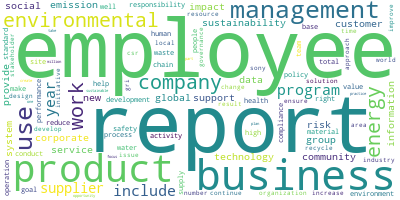

In [99]:
wordcloud.to_image()

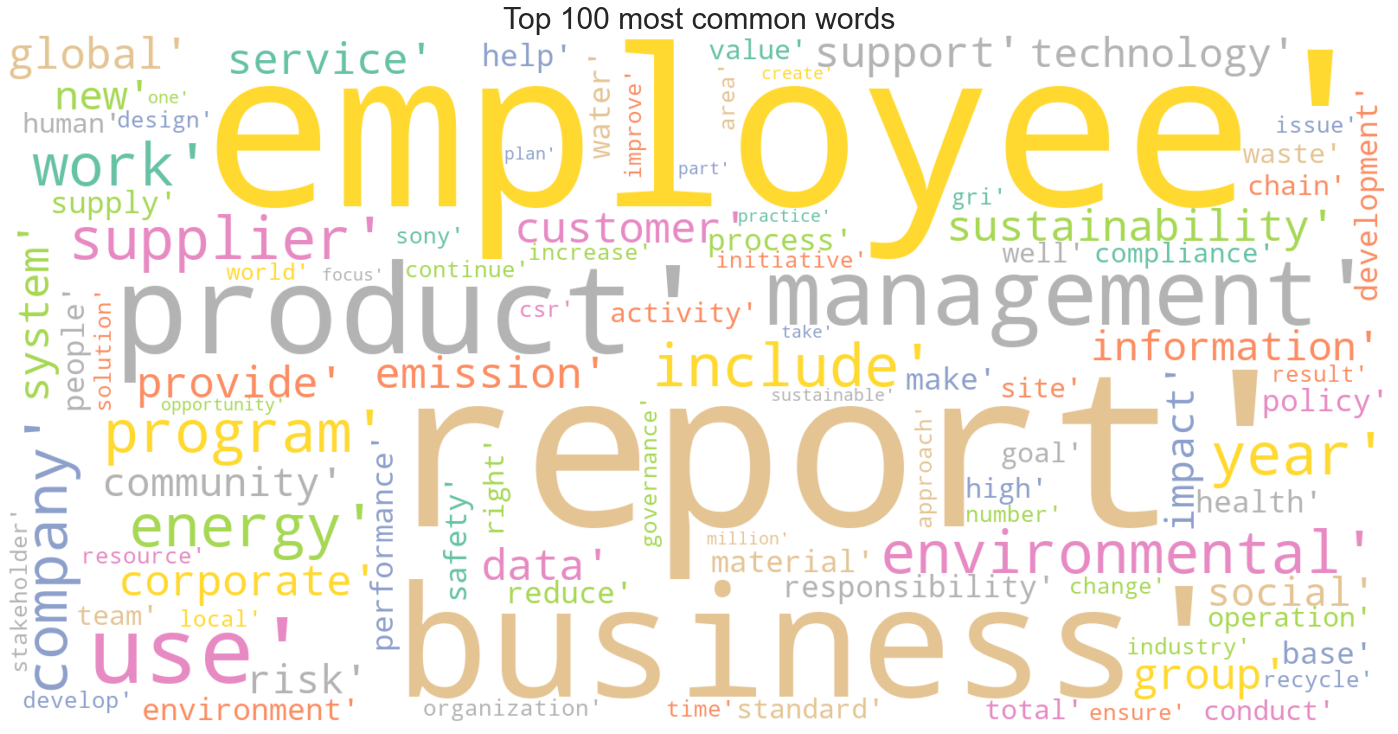

In [100]:
mostcommon = freqdist.most_common(100)
wordcloud = WordCloud(width=1600, height=800, background_color='white',colormap="Set2").generate(str(mostcommon))
fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 100 most common words', fontsize=30)
plt.tight_layout(pad=0)
plt.show()

In [101]:
fig=px.histogram(top50words,y="frequency", x="word",template="plotly_white",color_discrete_sequence=['#533A71'],
            title='Frequency of the top 50 words in the corpus',width=1700)
#fig.update_yaxes(categoryorder="total ascending")
fig.show()

IDEAS FOR FURTHER EDA (for later):
- wordclouds for pre-2015 vs post-2015
- wordclouds for Global 500 vs not
- wordclouds for FAANG vs not
see if there are any interesting differences there

In [102]:
# exporting the pre-processed dataset
df.to_csv('CR_dataset.csv',index=False)

---------

In [103]:
global500 = df.loc[df["Global 500"]=="yes"]
notg500 = df.loc[df["Global 500"]=="no"]

In [104]:
global500['report_lemmatized_filtered'] = global500['report_lemmatized_filtered'].astype(str)
notg500['report_lemmatized_filtered'] = notg500['report_lemmatized_filtered'].astype(str)

<ipython-input-104-629b054fe333>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-104-629b054fe333>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [105]:
g500_words_list = []
notg500_words_list = []

for string in global500['report_lemmatized_filtered2']:
    res = re.findall(r'\w+', string)
    g500_words_list.append(res)
    
for string in notg500['report_lemmatized_filtered2']:
    res = re.findall(r'\w+', string)
    notg500_words_list.append(res)

KeyError: 'report_lemmatized_filtered2'

In [ ]:
g500_flat = []
notg500_flat = []

for sublist in g500_words_list:
    for item in sublist:
        g500_flat.append(item)
        
for sublist in notg500_words_list:
    for item in sublist:
        notg500_flat.append(item)

In [ ]:
g500_freqdist = nltk.FreqDist(g500_flat)
g500_word_dist = pd.DataFrame.from_dict(g500_freqdist, orient='index')
g500_word_dist = g500_word_dist.reset_index().rename(columns={'index':'word',0:'frequency'})
g500_top50words = g500_word_dist.sort_values(by=['frequency'],ascending=False).head(100)
g500_top50words.head(10)

In [ ]:
notg500_freqdist = nltk.FreqDist(notg500_flat)
notg500_word_dist = pd.DataFrame.from_dict(notg500_freqdist, orient='index')
notg500_word_dist = notg500_word_dist.reset_index().rename(columns={'index':'word',0:'frequency'})
notg500_top50words = notg500_word_dist.sort_values(by=['frequency'],ascending=False).head(100)
notg500_top50words.head(10)

In [ ]:
notg500_top50wordsb = notg500_top50words.tail(35)
g500_top50wordsb = g500_top50words.tail(35)

g500tuplesb = [tuple(x) for x in g500_top50wordsb.values]
notg500typlesb = [tuple(x) for x in notg500_top50wordsb.values]

In [ ]:
wordcloud = WordCloud(width=1600, height=800, background_color='white', colormap="Set2").generate(str(notg500typlesb))
fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 15 to 50 Words - non-Global 500 companies', fontsize=30)
plt.tight_layout(pad=0)
plt.show()

In [ ]:
wordcloud = WordCloud(width=1600, height=800, background_color='white', colormap="Set2").generate(str(g500tuplesb))
fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 15 to 50 Words - Global 500 companies', fontsize=30)
plt.tight_layout(pad=0)
plt.show()

--------

In [ ]:
faang = df.loc[df["FAANG"]=="yes"]
notfaang = df.loc[df["FAANG"]=="no"]

faang['report_lemmatized_filtered'] = faang['report_lemmatized_filtered'].astype(str)
notfaang['report_lemmatized_filtered'] = notfaang['report_lemmatized_filtered'].astype(str)

faang['report_lemmatized_filtered2'] = faang['report_lemmatized_filtered'].map(lambda x: " ".join(eval(x)))
notfaang['report_lemmatized_filtered2'] = notfaang['report_lemmatized_filtered'].map(lambda x: " ".join(eval(x)))

In [ ]:
faang_words_list = []
notfaang_words_list = []

for string in faang['report_lemmatized_filtered2']:
    res = re.findall(r'\w+', string)
    faang_words_list.append(res)
    
for string in notfaang['report_lemmatized_filtered2']:
    res = re.findall(r'\w+', string)
    notfaang_words_list.append(res)
    
faang_flat = []
notfaang_flat = []

for sublist in faang_words_list:
    for item in sublist:
        faang_flat.append(item)
        
for sublist in notfaang_words_list:
    for item in sublist:
        notfaang_flat.append(item)

In [ ]:
faang_freqdist = nltk.FreqDist(g500_flat)
faang_word_dist = pd.DataFrame.from_dict(faang_freqdist, orient='index')
faang_word_dist = faang_word_dist.reset_index().rename(columns={'index':'word',0:'frequency'})
faang_top50words = faang_word_dist.sort_values(by=['frequency'],ascending=False).head(100)
faang_top50words.head(10)

In [ ]:
notfaang_freqdist = nltk.FreqDist(notg500_flat)
notfaang_word_dist = pd.DataFrame.from_dict(notfaang_freqdist, orient='index')
notfaang_word_dist = notfaang_word_dist.reset_index().rename(columns={'index':'word',0:'frequency'})
notfaang_top50words = notfaang_word_dist.sort_values(by=['frequency'],ascending=False).head(100)
notfaang_top50words.head(10)

In [ ]:
notfaang_top50wordsb = notfaang_top50words.tail(35)
faang_top50wordsb = faang_top50words.tail(35)

faangtuplesb = [tuple(x) for x in faang_top50wordsb.values]
notfaangtyplesb = [tuple(x) for x in notfaang_top50wordsb.values]

In [ ]:
wordcloud = WordCloud(width=1600, height=800, background_color='white', colormap="Set2").generate(str(faangtuplesb))
fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 15 to 50 Words - FAANG reports', fontsize=30)
plt.tight_layout(pad=0)
plt.show()

In [ ]:
wordcloud = WordCloud(width=1600, height=800, background_color='white', colormap="Set2").generate(str(notfaangtyplesb))
fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 15 to 50 Words - non-FAANG reports', fontsize=30)
plt.tight_layout(pad=0)
plt.show()

In [ ]:
# very similar as well